In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [3]:
df = pd.read_csv('dataset.csv')

In [4]:
df.head()

,Person ID,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
0,1,Male,27,Software Engineer,6.1,6,42,6,Overweight,126/83,77,4200,NaN
1,2,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
2,3,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
3,4,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
4,5,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea


## Exploratory Data Analysis (EDA)

In [5]:
def data_cleaning(df):
    
    df.columns = df.columns.str.lower().str.replace(' ', '_')
    df['sleep_disorder'] = df['sleep_disorder'].fillna('None')
    
    df[['systolic_bp', 'diastolic_bp']] = df['blood_pressure'].str.split('/', expand=True).astype(int)
    df.index = df['person_id']

    del df['person_id']
    del df['blood_pressure']

    return df

In [6]:
data = data_cleaning(df)
data.head()

,gender,age,occupation,sleep_duration,quality_of_sleep,physical_activity_level,stress_level,bmi_category,heart_rate,daily_steps,sleep_disorder,systolic_bp,diastolic_bp
person_id,,,,,,,,,,,,,
1,Male,27,Software Engineer,6.1,6,42,6,Overweight,77,4200,None,126,83
2,Male,28,Doctor,6.2,6,60,8,Normal,75,10000,None,125,80
3,Male,28,Doctor,6.2,6,60,8,Normal,75,10000,None,125,80
4,Male,28,Sales Representative,5.9,4,30,8,Obese,85,3000,Sleep Apnea,140,90
5,Male,28,Sales Representative,5.9,4,30,8,Obese,85,3000,Sleep Apnea,140,90


In [7]:
for col in data.columns:
    print(data[col].value_counts())
    print()

gender
Male      189
Female    185
Name: count, dtype: int64

age
43    34
44    30
37    20
38    20
50    20
31    18
32    17
53    17
59    16
39    15
45    14
33    13
30    13
29    13
35    12
36    12
41    12
49    11
57     9
52     9
42     9
51     8
54     7
58     6
28     5
40     4
48     3
55     2
56     2
34     2
27     1
Name: count, dtype: int64

occupation
Nurse                   73
Doctor                  71
Engineer                63
Lawyer                  47
Teacher                 40
Accountant              37
Salesperson             32
Software Engineer        4
Scientist                4
Sales Representative     2
Manager                  1
Name: count, dtype: int64

sleep_duration
7.2    36
6.0    31
7.8    28
6.5    26
6.1    25
7.7    24
6.6    20
7.1    19
8.1    15
7.3    14
8.4    14
6.3    13
8.5    13
8.0    13
6.2    12
8.2    11
7.6    10
6.4     9
7.9     7
7.4     5
6.7     5
7.5     5
6.8     5
8.3     5
5.9     4
6.9     3
5.8     2
Name: co

In [8]:
from sklearn.metrics import mutual_info_score

In [9]:
numerical = []
for n in data.dtypes[data.dtypes != 'object'].index:
    if n == 'quality_of_sleep':
        continue
    numerical.append(n)
categorical = []
for c in data.dtypes[data.dtypes == 'object'].index:
    categorical.append(c)

In [10]:
categorical_scores = []
for c in categorical:
    categorical_scores.append(mutual_info_score(data['quality_of_sleep'], data[c]))

In [11]:
mutual_info_data = pd.DataFrame(categorical_scores, index=categorical, columns=['Scores'])
mutual_info_data.sort_values('Scores', ascending=False)

,Scores
occupation,0.752868
bmi_category,0.253109
sleep_disorder,0.235115
gender,0.137336


In [12]:
correlation_data = data[numerical].corrwith(data['quality_of_sleep']).to_frame(name='Scores')
correlation_data.sort_values('Scores', ascending=False)

,Scores
sleep_duration,0.883213
age,0.473734
physical_activity_level,0.192896
daily_steps,0.016791
diastolic_bp,-0.110151
systolic_bp,-0.121632
heart_rate,-0.659865
stress_level,-0.898752


## Train Models

In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import KFold

In [14]:
df_full_train, df_test = train_test_split(data, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [15]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
df_full_train = df_full_train.reset_index(drop=True)

In [16]:
y_train = df_train['quality_of_sleep'].values
y_val = df_val['quality_of_sleep'].values
y_test = df_test['quality_of_sleep'].values
y_full_train = df_full_train['quality_of_sleep'].values

In [17]:
del df_train['quality_of_sleep']
del df_val['quality_of_sleep']
del df_test['quality_of_sleep']
del df_full_train['quality_of_sleep']

## Linear Model

In [30]:
train_dicts = df_train.to_dict(orient='records')

In [31]:
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

In [32]:
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [33]:
val_dicts = df_val.to_dict(orient='records')

In [34]:
X_val = dv.transform(val_dicts)

In [23]:
from sklearn.metrics import root_mean_squared_error as rmse
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error as mape

In [35]:
y_pred = linear_model.predict(X_val)
rmse(y_val, y_pred)

0.2815030814567863

In [25]:
mbe = np.mean(y_val - y_pred)
print(f'RMSE: {rmse(y_val, y_pred):.3f}')
print(f'R2: {r2_score(y_val, y_pred):.3f}')
print(f'MAPE: {mape(y_val, y_pred):.3f}')
print(f'MBE: {mbe:.3f}')

RMSE: 0.282
R2: 0.933
MAPE: 0.023
MBE: 0.031


In [36]:
train_scores = []
train_scores.append(rmse(y_val, y_pred))

## Full Train

In [84]:
full_train_dict = df_full_train.to_dict(orient='records')
test_dict = df_test.to_dict(orient='records')

In [85]:
X_full_train = dv.fit_transform(full_train_dict)
X_test = dv.transform(test_dict)

In [86]:
linear_model.fit(X_full_train, y_full_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [87]:
y_pred = linear_model.predict(X_test)
rmse(y_test, y_pred)

0.26751335198081777

In [90]:
full_train_scores = []
full_train_scores.append(rmse(y_test, y_pred))

## Decision Tree Model

In [91]:
dt = DecisionTreeRegressor(max_depth=10)
dt.fit(X_train, y_train)

,criterion,'squared_error'
,splitter,'best'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


In [38]:
y_pred = dt.predict(X_val)
train_scores.append(rmse(y_val, y_pred))
rmse(y_val, y_pred)

0.2581988897471611

In [65]:
for m in [1, 2, 3, 4, 5, 10]:
    dt = DecisionTreeRegressor(max_depth=m)
    dt.fit(X_train, y_train)

    y_pred = dt.predict(X_val)
    print(f'Min Depth: {m} {rmse(y_val, y_pred)}')

Min Depth: 1 0.655777336986474
Min Depth: 2 0.42305471087741786
Min Depth: 3 0.3035856602746251
Min Depth: 4 0.28328086700086985
Min Depth: 5 0.2581988897471611
Min Depth: 10 0.2581988897471611


In [66]:
for m in [1, 2, 3, 4, 5, 10]:
    dt = DecisionTreeRegressor(max_depth=10, min_samples_leaf=m)
    dt.fit(X_train, y_train)

    y_pred = dt.predict(X_val)
    print(f'Min Sample Leaf: {m} {rmse(y_val, y_pred)}')

Min Sample Leaf: 1 0.2581988897471611
Min Sample Leaf: 2 0.2581988897471611
Min Sample Leaf: 3 0.23551362310207594
Min Sample Leaf: 4 0.29171269478083445
Min Sample Leaf: 5 0.2431097348102005
Min Sample Leaf: 10 0.3279083857908508


## Full Train

In [92]:
for m in [1, 2, 3, 4, 5, 10, 11, 12, 13, 15, 20]:
    dt = DecisionTreeRegressor(max_depth=m)
    dt.fit(X_full_train, y_full_train)

    y_pred = dt.predict(X_test)
    print(f'Min Depth: {m} {rmse(y_test, y_pred)}')

Min Depth: 1 0.7401298224022531
Min Depth: 2 0.4798644349339735
Min Depth: 3 0.26220978405722933
Min Depth: 4 0.18546006344406127
Min Depth: 5 0.18596152415516434
Min Depth: 10 0.2581988897471611
Min Depth: 11 0.11547005383792516
Min Depth: 12 0.11547005383792516
Min Depth: 13 0.23094010767585033
Min Depth: 15 0.11547005383792516
Min Depth: 20 0.23094010767585033


In [93]:
for m in [1, 2, 3, 4, 5, 10]:
    dt = DecisionTreeRegressor(max_depth=10, min_samples_leaf=m)
    dt.fit(X_full_train, y_full_train)

    y_pred = dt.predict(X_test)
    print(f'Min Sample Leaf: {m} {rmse(y_test, y_pred)}')

Min Sample Leaf: 1 0.2581988897471611
Min Sample Leaf: 2 0.1387777332977422
Min Sample Leaf: 3 0.2341572754146871
Min Sample Leaf: 4 0.25021472260322214
Min Sample Leaf: 5 0.32915154676947933
Min Sample Leaf: 10 0.3031003753243891


In [95]:
dt = DecisionTreeRegressor(max_depth=10)
dt.fit(X_full_train, y_full_train)

y_pred = dt.predict(X_test)
full_train_scores.append(rmse(y_test, y_pred))
rmse(y_test, y_pred)

0.11547005383792516

## Random Forest

In [39]:
rf = RandomForestRegressor(n_estimators=50, random_state=1)
rf.fit(X_train, y_train)

,n_estimators,50
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [40]:
y_pred = rf.predict(X_val)
train_scores.append(rmse(y_val, y_pred))
rmse(y_val, y_pred)

0.2176357813718446

In [96]:
for num in range(10, 201, 10):
    rf = RandomForestRegressor(n_estimators=num, random_state=1)
    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_val)
    print(f'Num: {num} RMSE: {rmse(y_val, y_pred):.3f}')

Num: 10 RMSE: 0.248
Num: 20 RMSE: 0.222
Num: 30 RMSE: 0.226
Num: 40 RMSE: 0.219
Num: 50 RMSE: 0.218
Num: 60 RMSE: 0.227
Num: 70 RMSE: 0.229
Num: 80 RMSE: 0.235
Num: 90 RMSE: 0.238
Num: 100 RMSE: 0.236
Num: 110 RMSE: 0.233
Num: 120 RMSE: 0.231
Num: 130 RMSE: 0.230
Num: 140 RMSE: 0.227
Num: 150 RMSE: 0.227
Num: 160 RMSE: 0.224
Num: 170 RMSE: 0.228
Num: 180 RMSE: 0.229
Num: 190 RMSE: 0.230
Num: 200 RMSE: 0.230


## Full Train

In [96]:
for num in range(10, 201, 10):
    rf = RandomForestRegressor(n_estimators=num, random_state=1)
    rf.fit(X_full_train, y_full_train)

    y_pred = rf.predict(X_test)
    print(f'Num: {num} RMSE: {rmse(y_test, y_pred):.3f}')

Num: 10 RMSE: 0.191
Num: 20 RMSE: 0.183
Num: 30 RMSE: 0.190
Num: 40 RMSE: 0.196
Num: 50 RMSE: 0.201
Num: 60 RMSE: 0.198
Num: 70 RMSE: 0.189
Num: 80 RMSE: 0.184
Num: 90 RMSE: 0.182
Num: 100 RMSE: 0.181
Num: 110 RMSE: 0.182
Num: 120 RMSE: 0.185
Num: 130 RMSE: 0.186
Num: 140 RMSE: 0.188
Num: 150 RMSE: 0.186
Num: 160 RMSE: 0.186
Num: 170 RMSE: 0.185
Num: 180 RMSE: 0.185
Num: 190 RMSE: 0.186
Num: 200 RMSE: 0.186


In [97]:
rf = RandomForestRegressor(n_estimators=20, random_state=1)
rf.fit(X_full_train, y_full_train)
y_pred = rf.predict(X_test)
full_train_scores.append(rmse(y_test, y_pred))
rmse(y_test, y_pred)

0.18303005217723126

## Gradient Boosting

In [41]:
import xgboost as xgb

In [42]:
features = list(dv.get_feature_names_out())
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [43]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [44]:
xgb_params = {
    'eta': 0.9, 
    'max_depth': 5,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 4,
    'verbosity': 1,
}

In [45]:
xgb_model = xgb.train(xgb_params, dtrain, evals=watchlist, num_boost_round=10)

[0]	train-rmse:0.22022	val-rmse:0.28284
[1]	train-rmse:0.08331	val-rmse:0.23264
[2]	train-rmse:0.04585	val-rmse:0.18475
[3]	train-rmse:0.02714	val-rmse:0.16648
[4]	train-rmse:0.01621	val-rmse:0.15796
[5]	train-rmse:0.01037	val-rmse:0.15701
[6]	train-rmse:0.00666	val-rmse:0.15751
[7]	train-rmse:0.00455	val-rmse:0.15773
[8]	train-rmse:0.00359	val-rmse:0.15703
[9]	train-rmse:0.00225	val-rmse:0.15718


In [46]:
y_pred = xgb_model.predict(dval)
train_scores.append(rmse(y_val, y_pred))
rmse(y_val, y_pred)

0.1571832150220871

In [288]:
feat_imp = xgb_model.get_score(importance_type='gain')
feat_df = pd.DataFrame(feat_imp.items(), columns=['Features', 'Importance'])
feat_df.sort_values('Importance', ascending=False)

,Features,Importance
17,sleep_duration,18.955997
10,occupation=Doctor,15.078745
18,stress_level,3.773186
3,bmi_category=Obese,1.794476
8,heart_rate,0.818005
0,age,0.323958
5,daily_steps,0.258380
13,occupation=Scientist,0.100369
4,bmi_category=Overweight,0.062213
6,diastolic_bp,0.045007


## Full Train

In [101]:
dfulltrain = xgb.DMatrix(X_full_train, label=y_full_train, feature_names=list(dv.get_feature_names_out()))
dtest = xgb.DMatrix(X_test, label=y_test, feature_names=list(dv.get_feature_names_out()))

In [102]:
watchlist = [(dfulltrain, 'full_train'), (dtest, 'test')]

In [115]:
xgb_params = {
    'eta': 0.8, 
    'max_depth': 5,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

In [116]:
xgb_model = xgb.train(xgb_params, dfulltrain, evals=watchlist, num_boost_round=15)

[0]	full_train-rmse:0.29921	test-rmse:0.46078
[1]	full_train-rmse:0.11359	test-rmse:0.24917
[2]	full_train-rmse:0.06340	test-rmse:0.20852
[3]	full_train-rmse:0.04276	test-rmse:0.20259
[4]	full_train-rmse:0.03313	test-rmse:0.20090
[5]	full_train-rmse:0.02790	test-rmse:0.19987
[6]	full_train-rmse:0.02087	test-rmse:0.19824
[7]	full_train-rmse:0.01628	test-rmse:0.19392
[8]	full_train-rmse:0.01173	test-rmse:0.19269
[9]	full_train-rmse:0.00778	test-rmse:0.19294
[10]	full_train-rmse:0.00535	test-rmse:0.19272
[11]	full_train-rmse:0.00368	test-rmse:0.19254
[12]	full_train-rmse:0.00318	test-rmse:0.19232
[13]	full_train-rmse:0.00230	test-rmse:0.19228
[14]	full_train-rmse:0.00193	test-rmse:0.19227


In [117]:
y_pred = xgb_model.predict(dtest)
full_train_scores.append(rmse(y_test, y_pred))
rmse(y_test, y_pred)

0.19227372109889984

In [132]:
models = ['Linear Regression', 'DecisionTreeRegressor', 'RandomForestRegressor', 'XGBoost']
train_scores_df = pd.DataFrame({
    'Models': models, 
    'Scores': train_scores
})
full_train_scores_df = pd.DataFrame({
    'Models': models, 
    'Scores': full_train_scores
})
train_scores_df = train_scores_df.sort_values('Scores', ascending=False)
full_train_scores_df = full_train_scores_df.sort_values('Scores', ascending=False)

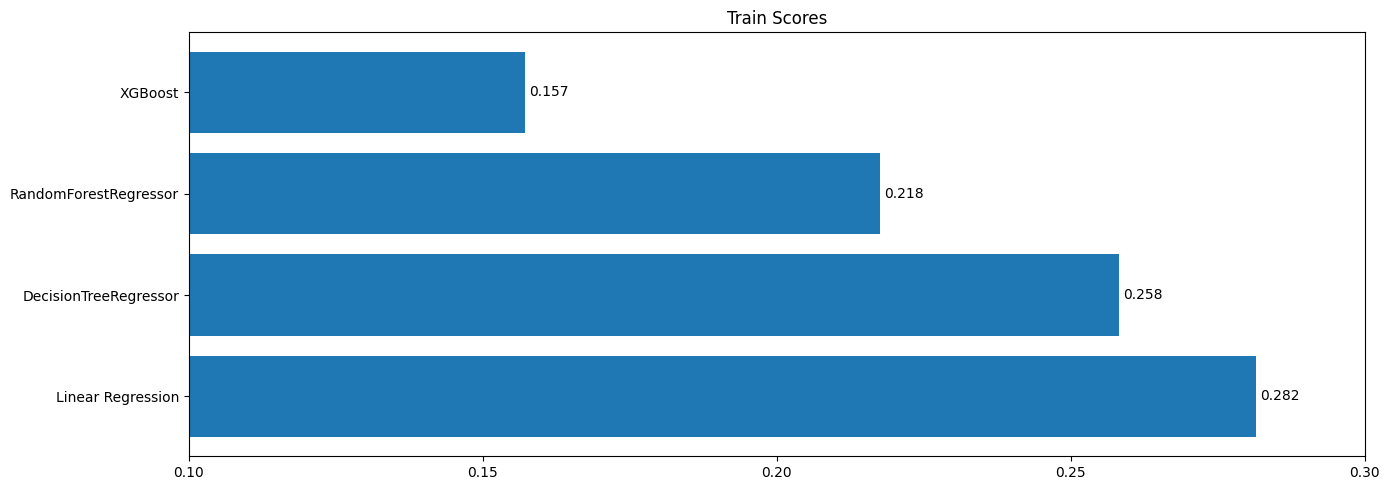

In [133]:
plt.figure(figsize=(14, 5))
bars = plt.barh(train_scores_df['Models'], train_scores_df['Scores'])
plt.bar_label(bars, fmt='%.3f', padding=3)
plt.xlim(0.1, 0.3)
plt.xticks(np.arange(0.1, 0.31, 0.05))
plt.title('Train Scores')
plt.tight_layout()

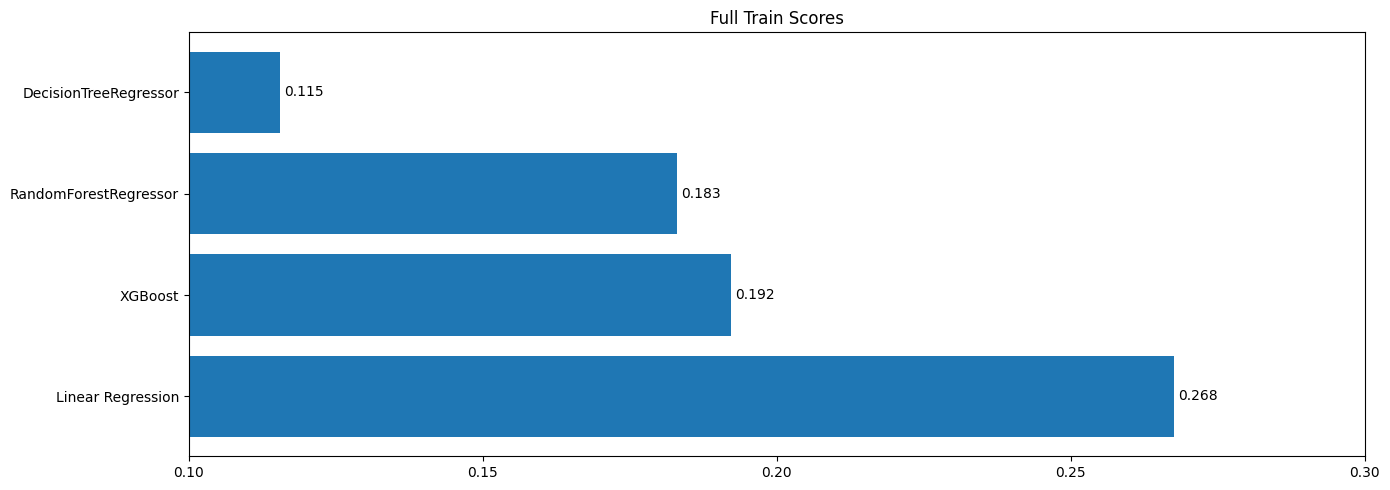

In [134]:
plt.figure(figsize=(14, 5))
bars = plt.barh(full_train_scores_df['Models'], full_train_scores_df['Scores'])
plt.bar_label(bars, fmt='%.3f', padding=3)
plt.xlim(0.1, 0.3)
plt.xticks(np.arange(0.1, 0.31, 0.05))
plt.title('Full Train Scores')
plt.tight_layout()